# Calculating the BIC for Mock Data using XD

## Importing Modules

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/nb00699/Accreted_Stars_GALAH_Paper/XD/extreme-deconvolution-main/py')
from extreme_deconvolution import extreme_deconvolution
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## Extracting Data from the CSV

In [151]:
filename = "generated_data_with_errors.csv"
data = pd.read_csv(filename)

# Extract dimensions, errors, and labels
num_dimensions = len([col for col in data.columns if col.startswith("Dimension")])
X = data[[f"Dimension_{i+1}" for i in range(num_dimensions)]].values  # Data points
errors = data[[f"Error_Dimension_{i+1}" for i in range(num_dimensions)]].values  # Errors
labels = data["Component_Label"].values  # True labels (if needed, not used for XD)
print(X.shape)

(10000, 5)


## Defining the BIC

In [152]:
def BIC(log_likelihood, num_parameters, num_samples):
    """
    Compute the Bayesian Information Criterion (BIC).
    
    Parameters:
        log_likelihood (float): Total log-likelihood of the model.
        num_parameters (int): Number of free parameters in the model.
        num_observations (int): Number of observations.
        
    Returns:
        float: BIC score.
    """
    return -2 * log_likelihood + num_parameters * np.log(num_samples)

## Initialising Variables

In [153]:
num_components = np.arange(1, 21)  # Range of components to test, maximum is arbritary
num_samples = len(X)  # Number of data points
num_dim = X.shape[1]  # Number of dimensions

print('The number of dimensions:', num_dim)
print('The number of samples:', num_samples)
print('The number of components:', int(labels[-1] + 1))

The number of dimensions: 5
The number of samples: 10000
The number of components: 6


## Calculating the BIC scores

(10000, 5)
(10000, 5)


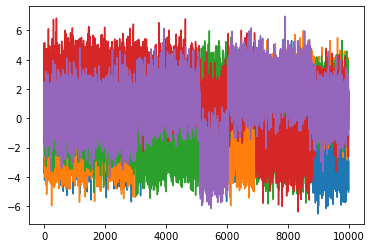

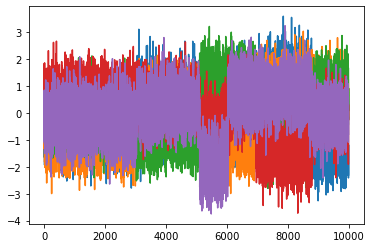

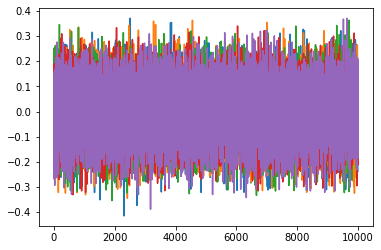

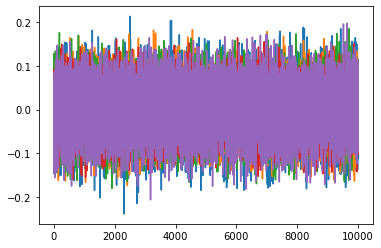

1 components fitted with average log-likelihood: -10.026289917872
2 components fitted with average log-likelihood: -9.69735469410509
3 components fitted with average log-likelihood: -9.546099936420593
4 components fitted with average log-likelihood: -9.472430352652456
5 components fitted with average log-likelihood: -9.44376810527759
6 components fitted with average log-likelihood: -9.413774643278078
7 components fitted with average log-likelihood: -9.41275929588392
8 components fitted with average log-likelihood: -9.410277398636554
9 components fitted with average log-likelihood: -9.40877647170055
10 components fitted with average log-likelihood: -9.407310838042513
11 components fitted with average log-likelihood: -9.452929956262496
12 components fitted with average log-likelihood: -9.436243076754023
13 components fitted with average log-likelihood: -9.41341918148994
14 components fitted with average log-likelihood: -9.432735814842486
15 components fitted with average log-likelihood: 

In [154]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scale the errors
errors_scaled = errors / scaler.scale_

print(X.shape)
print(errors.shape)

plt.plot(X)
plt.show()

plt.plot(X_scaled)
plt.show()

plt.plot(errors)
plt.show()

plt.plot(errors_scaled)
plt.show()

# Store BIC scores
BIC_scores = []

for n in num_components:
    # Fit a GMM to initialize parameters using standardized data
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type='full')
    gmm.fit(X)  # Fit GMM to the scaled data

    # Extract initial parameters from the GMM
    initamp = gmm.weights_  # Component weights
    initmean = gmm.means_   # Component means
    initcovar = gmm.covariances_  # Component covariance matrices

    # Perform Extreme Deconvolution
    try:
        XD_avg_LL = extreme_deconvolution(
            X, errors, initamp, initmean, initcovar
        )
        print(f"{n} components fitted with average log-likelihood: {XD_avg_LL}")
    except Exception as e:
        print(f"XD failed for {n} components: {e}")
        continue

    # Compute total log-likelihood
    LL = XD_avg_LL * num_samples

    # Correct formula for number of free parameters
    num_parameters = n * (1 + num_dim + num_dim * (num_dim + 1) // 2) - 1

    # Calculate BIC
    bic_value = BIC(LL, num_parameters, num_samples)
    BIC_scores.append(bic_value)

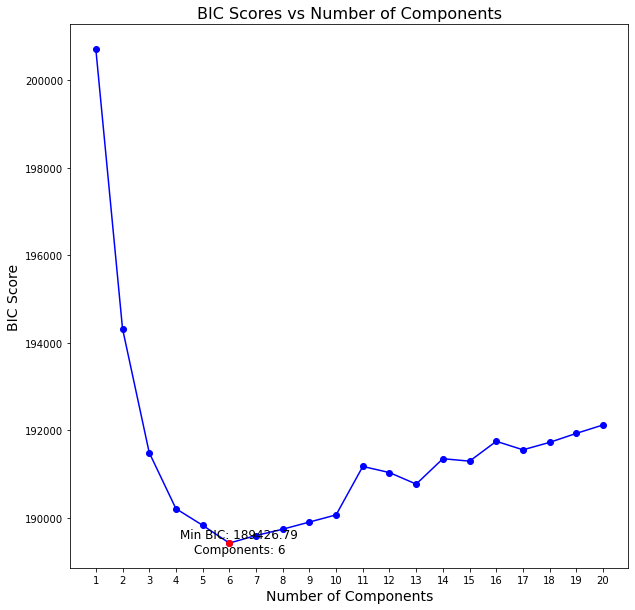

In [155]:
# Plot the BIC scores
plt.figure(figsize=(10, 10))
plt.plot(num_components, BIC_scores, marker='o', color='blue')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('BIC Score', fontsize=14)
plt.title('BIC Scores vs Number of Components', fontsize=16)

# Set x-axis ticks to integers
plt.xticks(ticks=np.arange(min(num_components), max(num_components) + 1, step=1))

# Highlight the minimum BIC
min_bic_index = np.argmin(BIC_scores)
plt.scatter(num_components[min_bic_index], BIC_scores[min_bic_index], color='red', zorder=5)
plt.annotate(f"Min BIC: {BIC_scores[min_bic_index]:.2f}\nComponents: {num_components[min_bic_index]}", 
             (num_components[min_bic_index], BIC_scores[min_bic_index]),
             textcoords="offset points", xytext=(10, -10), ha='center', fontsize=12)

plt.show()